In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge customers with transactions
merged_data = transactions.merge(customers, on='CustomerID', how='left')

# Check the first few rows
print(merged_data.head())


  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price     CustomerName         Region  SignupDate  
0      300.68  300.68   Andrea Jenkins         Europe  2022-12-03  
1      300.68  300.68  Brittany Harvey           Asia  2024-09-04  
2      300.68  300.68  Kathryn Stevens         Europe  2024-04-04  
3      601.36  300.68  Travis Campbell  South America  2024-04-11  
4      902.04  300.68    Timothy Perez         Europe  2022-03-15  


**Feature Engineering:**

We will create features such as:

Customer demographic features (e.g., region, signup date).

Transaction features (e.g., total spending, number of purchases, frequency of purchases, and types of products bought).


In [ ]:
# Extract transaction data for each customer
customer_spending = merged_data.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    num_transactions=('TransactionID', 'count')
).reset_index()

# Add demographic features: region and days since signup
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
customers['days_since_signup'] = (pd.to_datetime('today') - customers['SignupDate']).dt.days

# Merge customer demographics with transactional data
customer_profiles = customers[['CustomerID', 'Region', 'days_since_signup']].merge(customer_spending, on='CustomerID')

# One-hot encode the region feature
customer_profiles = pd.get_dummies(customer_profiles, columns=['Region'], drop_first=True)

# Scale the data for clustering
scaler = StandardScaler()
customer_profiles_scaled = scaler.fit_transform(customer_profiles.drop('CustomerID', axis=1))

# Check the final customer profile data
print(customer_profiles.head())


  CustomerID  days_since_signup  total_spent  num_transactions  Region_Europe  \
0      C0001                929      3354.52                 5          False   
1      C0002               1076      1862.74                 4          False   
2      C0003                323      2725.38                 4          False   
3      C0004                838      5354.88                 8          False   
4      C0005                893      2034.24                 3          False   

   Region_North America  Region_South America  
0                 False                  True  
1                 False                 False  
2                 False                  True  
3                 False                  True  
4                 False                 False  


**Clustering:**

We will choose a clustering algorithm (e.g., KMeans, DBSCAN, Agglomerative Clustering), and determine the appropriate number of clusters (between 2 and 10).

We will evaluate clustering using the Davies-Bouldin Index (DB Index) and other metrics.

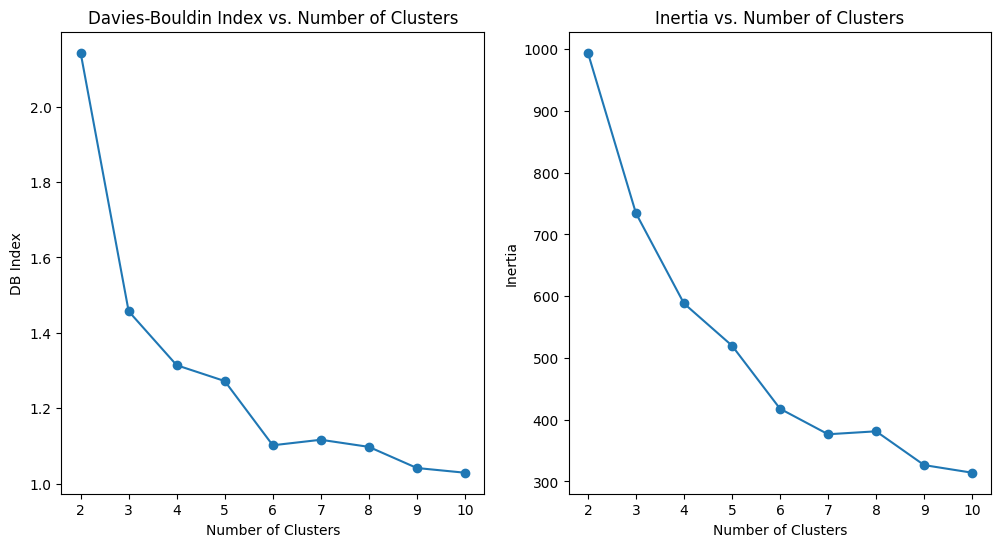

Optimal number of clusters: 10


In [ ]:
# Fit KMeans for different numbers of clusters (between 2 and 10)
db_scores = []
inertia_scores = []
num_clusters_range = range(2, 11)

for n_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    customer_profiles['Cluster'] = kmeans.fit_predict(customer_profiles_scaled)

    # Calculate Davies-Bouldin Index (DB Index)
    db_index = davies_bouldin_score(customer_profiles_scaled, customer_profiles['Cluster'])
    db_scores.append(db_index)
    inertia_scores.append(kmeans.inertia_)

# Plot DB Index and Inertia scores to choose the optimal number of clusters
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(num_clusters_range, db_scores, marker='o')
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')

plt.subplot(1, 2, 2)
plt.plot(num_clusters_range, inertia_scores, marker='o')
plt.title('Inertia vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Select the best number of clusters based on DB Index
optimal_clusters = num_clusters_range[np.argmin(db_scores)]
print(f"Optimal number of clusters: {optimal_clusters}")


**Visualization:**

Visualize the customer segments in a 2D space using PCA (Principal Component Analysis) for dimensionality reduction.

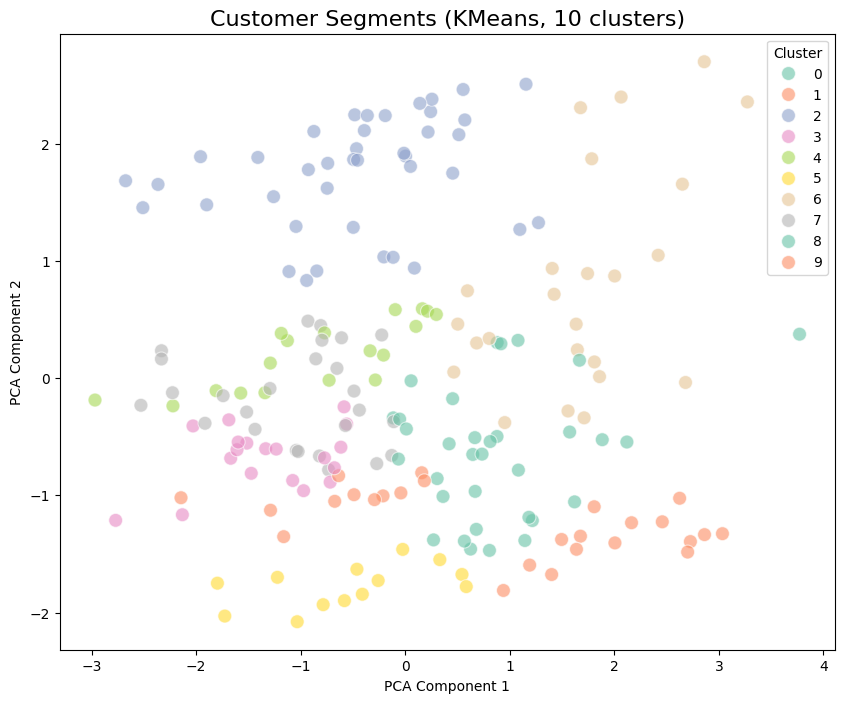

In [ ]:
# Apply PCA for dimensionality reduction (to 2D)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(customer_profiles_scaled)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = customer_profiles['Cluster']

# Plot the clusters in 2D
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette='Set2', s=100, alpha=0.6, edgecolor='w', legend='full')
plt.title(f'Customer Segments (KMeans, {optimal_clusters} clusters)', fontsize=16)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


**Evaluate the Results:**

Calculate and report the DB Index.
Provide a visual representation of the clusters.


In [ ]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Score for the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_profiles['Cluster'] = kmeans.fit_predict(customer_profiles_scaled)

sil_score = silhouette_score(customer_profiles_scaled, customer_profiles['Cluster'])
print(f"Silhouette Score for {optimal_clusters} clusters: {sil_score}")


Silhouette Score for 10 clusters: 0.30338111598745826
